In [1]:
pip install fastai -U

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.0.11)


In [4]:
from fastai.text.all import *

In [5]:
## Deeper into mid level API (fastai)
path = untar_data(URLs.IMDB)

In [6]:
path.ls()

(#7) [Path('/root/.fastai/data/imdb/tmp_lm'),Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/tmp_clas'),Path('/root/.fastai/data/imdb/test'),Path('/root/.fastai/data/imdb/README'),Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/imdb.vocab')]

In [7]:
# Transforms
files = get_text_files(path, folders=['train', 'valid'])
txts = L(o.open().read() for o in files[:2000])

In [8]:
tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#236) ['xxbos','[','i','saw','this','movie','once','late','on','a'...]

In [9]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

tensor([   2, 4024,   18,  238,   20,   26,  353,  949,   35,   12])

In [10]:
nums_dec = num.decode(nums[0][:10]); nums_dec

(#10) ['xxbos','[','i','saw','this','movie','once','late','on','a']

In [11]:
tok.decode(nums_dec)

'xxbos [ i saw this movie once late on a'

In [13]:
## Writing your own Transform
def f(x:int): return x + 1
tfm = Transform(f)
tfm(2), tfm(3.0)

(3, 3.0)

In [27]:
@Transform
def f(x:int): return x + 1
f(2.0), f(2)

(2.0, 3)

In [29]:
## Using the setup, encode and decode.
## For that we need to subclass Transform

class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items) / len(items)
    def encodes(self, x): return x - self.mean
    def decodes(self, x): return x + self.mean

In [32]:
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)
tfm.mean, y, z

(3.0, -1.0, 2.0)

In [38]:
x = NormalizeMean()
print(x)

NormalizeMean:
encodes: (object,object) -> encodes
decodes: (object,object) -> decodes



In [55]:
## Pipeline: takes in a list of transforms
# pipeline will then automatically composes and calls Transform and performs the  transformations in order

tfms = Pipeline([tok, num])
t = tfms(txts[0]); t[:20]

tensor([   2, 4024,   18,  238,   20,   26,  353,  949,   35,   12, 1101,  237,
        1660,   11,   52,   18,   57,   32,  133,   58])

In [57]:
tfms.decode(t)[:100]

"xxbos [ i saw this movie once late on a public tv station , so i do n't know if it 's on video or no"

In [58]:
## While calling pipeline the setup behavior is not the same as when calling Transform
## So we will use TfmdLists for a proper set-up

tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

In [59]:
t = tls[0]; t[:20]

tensor([   2, 3926,   19,  234,   20,   30,  302,  564,   35,   13, 1038,  265,
        1546,   11,   52,   19,   59,   36,  141,   64])

In [62]:
tls.decode(t)[:100]

"xxbos [ i saw this movie once late on a public tv station , so i do n't know if it 's on video or no"

In [66]:
tls.show(t)

xxbos [ i saw this movie once late on a public tv station , so i do n't know if it 's on video or not . ] 

 xxmaj this is one of the " baby xxmaj xxunk " ( sic ) that xxmaj shirley xxmaj temple did in the early 1930s . xxmaj it is hard to believe that anyone would let their daughter be in this racy little film which today might just be considered this side of " kiddie porn " . 

 xxmaj shirley xxmaj temple stars in a cast which probably has an average age of 5 . xxmaj they are all in diapers , and are in a saloon which serves milk instead of alcohol . xxmaj the " cash " is in the form of lollipops . 

 xxmaj shirley playing a " femme fatale " xxunk up to the bar and talks to soldiers who make suggestive comments about her ( ! ) . xxmaj but xxmaj shirley does n't need really their lollipops / cash because her purse is full of ones from other " men " . 

 xxmaj meanwhile a little black boy does a suggestive dance on a nearby table ( ! ) . 

 xxmaj what a strange film . . . infants using

In [67]:
## TfmdLists can handle both training and validation set hence the plural names

cut = int(len(files) * 0.8)
splits = [list(range(cut)), list(range(cut, len(files)))]
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize],
                splits=splits)

In [68]:
tls.valid[0][:20]

tensor([   2,   19,  107,  234,   20,   32,   69,   19,   25,  209, 1026,   56,
         758,  176,  178,   12,   89,   36,   85,  123])

In [70]:
## If we label for text classfication we will need to process them as well 

lbls = files.map(parent_label)
lbls

(#25000) ['neg','neg','neg','neg','neg','neg','neg','neg','neg','neg'...]

In [74]:
## We need to <Transform> the labels, by grabbing the unique words and build the vocab
# Then transform the string into vocabs
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0])

((#2) ['neg','pos'], TensorCategory(0))

In [78]:
## Doing the whole setup on our list of files

tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[-5:]

(#5) [TensorCategory(1),TensorCategory(1),TensorCategory(1),TensorCategory(1),TensorCategory(1)]

In [87]:
## This results in two different objects for inputs and targets
## This is where datasets can help 

x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])
x, y = dsets[0]
x[:20],y

(tensor([   2, 3926,   19,  234,   20,   30,  302,  564,   35,   13, 1038,  265,
         1546,   11,   52,   19,   59,   36,  141,   64]), TensorCategory(0))

In [88]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x,y = dsets.valid[0]
x[:20], y

(tensor([   2,   19,  107,  234,   20,   32,   69,   19,   25,  209, 1026,   56,
          758,  176,  178,   12,   89,   36,   85,  123]), TensorCategory(1))

In [90]:
## Datasets can also decode or show directly

t = dsets.valid[0]
dsets.decode(t)

("xxbos i first saw this film when i was around 6 or 7 years old and did n't really think it was anything particularly special . xxup as time went on i watched it a few more times and it started to grow on me as i started to understand the morals of the film , which i will come to later . xxmaj for a while i left this film alone and did n't watch it for a while . xxmaj when looking for an old classic film to watch a few weeks ago ( now being 15 ) , i dug out the xxup vhs of homeward bound . xxmaj after watching this i was left on a natural high that i could n't really explain . xxmaj the film gives an overwhelming sense of joy that you never really expect . xxmaj the films nature of three completely different animals collaborating together to find their way home really sends a message home that no matter how different you are you can always find common ground , something that you all need . xxmaj the way the personalities of the characters is chosen is truly fantastic . xxmaj in that y

In [91]:
## Last step is to pass the dataset to dataloaders

dls = dsets.dataloaders(bs=64, before_batch=pad_input)

In [92]:
## Full code necessary for preparation of data for text classification 

tfms = [[Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize()]]
files = get_text_files(path, folders=['train', 'test'])
splits = GrandparentSplitter(valid_name='test')(files)
dsets = Datasets(files, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

In [93]:
## Above is identical to this:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path), CategoryBlock),
    get_y = parent_label,
    get_items = partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

In [3]:
## Applying the mid-level API

from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [4]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [37]:
files = get_image_files(path / 'images')

In [24]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs):
        img1, img2, same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1, t2 = tensor(img1), tensor(img2)
            t1, t2 = t1.permute(2, 0, 1), t2.permute(2, 0, 1)
        else: t1, t2 = img1, img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1, line, t2], dim=2),
                          title=same_breed, ctx=ctx)

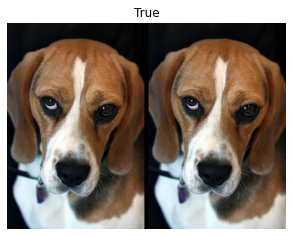

In [25]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show();

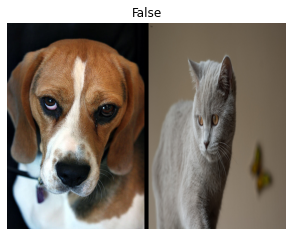

In [27]:
## Trying different images
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show();

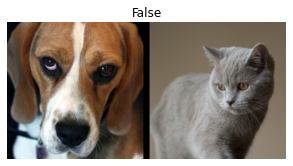

In [33]:
## Here the Resize only applied to the images and not the boolean flag.
s2 = Resize(224)(s1)
s2.show();

In [34]:
# Now we can build our transform to get the data ready

def label_func(fname):
    return re.match(r"^(.*)_\d+.jpg$", fname.name).groups()[0]

In [46]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) 
                          for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: 
            cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same

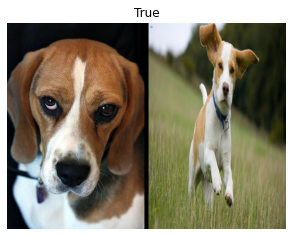

In [47]:

splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits=splits)
tfm(files[0]).show();

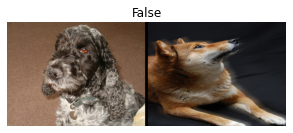

In [51]:
# In mid level api we have TfmdLists and Datasets to apply transforms
# First applies pipline of transforms while later applies pipline transforms in parallel to build tuples
# Our main transform already built tuples so we can use TfmdLists

tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0)

In [52]:
## calling DataLoaders

dls = tls.dataloaders(after_item=[Resize(224), ToTensor],
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])